In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,csr_matrix,csr_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
%matplotlib inline

In [2]:
data = pd.read_csv('data/round_train.csv')
data1 = pd.read_csv('data/round_test.csv',header=None)
data1.columns = data.columns
data = pd.concat([data,data1])

In [3]:
data.shape

(231125, 12)

In [4]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [5]:
inds = {num:ind for ind,num in enumerate(pd.unique(data.Player_Number))}

In [6]:
data.insert(5,'Player_Index',[inds[num] for num in data.Player_Number])

In [7]:
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])

In [8]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)
n_tournaments = len(data.groupby(['Tournament_Year','Permanent_Tournament_#']))

In [9]:
print n_players,n_rounds,n_tournaments

2461 2549 565


In [10]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((loader['data'],loader['indices'],loader['indptr']),shape = loader['shape'])

In [11]:
def inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA,window_size=28):
    mat = csc_matrix((n_players*n_tournament_groups,n_players),dtype=float)
    mat_1 = csc_matrix((n_players*n_tournament_groups,n_players),dtype=float)
    for j in rounds_to_inflate:
        mat += bmat([[load_sparse_csc('rounds/%d.npz' % j)*BETA**abs(tournament_group-k)] for k in range(1,n_tournament_groups+1)],format='csc')
        mat_1 += bmat([[(load_sparse_csc('rounds/%d.npz' % j)!=0).astype(float)*BETA**abs(tournament_group-k)] for k in range(1,n_tournament_groups+1)],format='csc')
    inflate.__dict__[tournament_group] = (mat,mat_1)
    out_mat = bmat([[inflate.__dict__[i][0][max(0,tournament_group-window_size)*n_players:n_players*tournament_group] for i in range(max(1,tournament_group-window_size+1),tournament_group+1)]],format='csc')
    out_mat1 = bmat([[inflate.__dict__[i][1][max(0,tournament_group-window_size)*n_players:n_players*tournament_group] for i in range(max(1,tournament_group-window_size+1),tournament_group+1)]],format='csc')
    return (out_mat,out_mat1)

In [12]:
def alpha(A,a):
    w,v = eigs(A,k=1,which='LM')
    return a/w[0].real

In [13]:
def solve(mat,mat_1,a,min_reps,x_guess=None,x_guess1=None):
    S = eye(mat.shape[0],format='csc')-alpha(mat,a)*mat
    w_a = gmres(S,mat.sum(1),x0=x_guess)[0]
    
    S = eye(mat_1.shape[0],format='csc')-alpha(mat_1,a)*mat_1 
    w_g = gmres(S,mat_1.sum(1),x0=x_guess1)[0]
    
    w_a[w_g<min_reps]=0
    solve.w_a = w_a
    solve.w_g = w_g
    
    return ((w_a/w_g)[-n_players:],w_g[-n_players:])

In [14]:
ranks,reps = [],[]
BETA = .85
a = .8
bin_size = 4
window_size = 28
n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
current_group = 0
tournament_groups=[set()]
tournaments = set()
rounds_to_inflate = []
for round_ind,df in enumerate(rounds):
    df = df[1]
    tournament_groups[current_group].add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    tournaments.add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    tournament_group = len(tournaments)/bin_size
    rounds_to_inflate.append(round_ind)
    if tournament_group>current_group:
        A,G = inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA)
        if current_group==0:
            res = solve(A,G,a,1)
            ranks.append(res[0])
            reps.append(res[1])
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
            tournament_groups.append(set())
            rounds_to_inflate = []
        else:
            w_a_approx = np.append(solve.w_a[0 if tournament_group<=window_size else n_players:],solve.w_a[-n_players:])
            w_g_approx = np.append(solve.w_g[0 if tournament_group<=window_size else n_players:],solve.w_g[-n_players:])
            res = solve(A,G,a,1,w_a_approx,w_g_approx)
            ranks.append(res[0])
            reps.append(res[1])
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
            tournament_groups.append(set())
            rounds_to_inflate = []

Tournament Group 1 done
Tournament Group 2 done
Tournament Group 3 done
Tournament Group 4 done
Tournament Group 5 done
Tournament Group 6 done
Tournament Group 7 done
Tournament Group 8 done
Tournament Group 9 done
Tournament Group 10 done
Tournament Group 11 done
Tournament Group 12 done
Tournament Group 13 done
Tournament Group 14 done
Tournament Group 15 done
Tournament Group 16 done
Tournament Group 17 done
Tournament Group 18 done
Tournament Group 19 done
Tournament Group 20 done
Tournament Group 21 done
Tournament Group 22 done
Tournament Group 23 done
Tournament Group 24 done
Tournament Group 25 done
Tournament Group 26 done
Tournament Group 27 done
Tournament Group 28 done
Tournament Group 29 done
Tournament Group 30 done
Tournament Group 31 done
Tournament Group 32 done
Tournament Group 33 done
Tournament Group 34 done
Tournament Group 35 done
Tournament Group 36 done
Tournament Group 37 done
Tournament Group 38 done
Tournament Group 39 done
Tournament Group 40 done
Tournamen

In [15]:
for i in range(len(ranks)):
    df = pd.DataFrame({'rank':ranks[i],'reps':reps[i]}).dropna()
    print i,df['rank'].describe()

0 count    237.000000
mean       0.995557
std        0.027138
min        0.884476
25%        0.980301
50%        0.999290
75%        1.013299
max        1.059954
Name: rank, dtype: float64
1 count    326.000000
mean       0.991015
std        0.029849
min        0.866760
25%        0.975756
50%        0.995812
75%        1.011625
max        1.062674
Name: rank, dtype: float64
2 count    347.000000
mean       0.988227
std        0.030339
min        0.850534
25%        0.974987
50%        0.994303
75%        1.007393
max        1.061747
Name: rank, dtype: float64
3 count    376.000000
mean       0.985455
std        0.033028
min        0.849368
25%        0.971807
50%        0.993038
75%        1.008081
max        1.055649
Name: rank, dtype: float64
4 count    407.000000
mean       0.983878
std        0.032772
min        0.865925
25%        0.968371
50%        0.991790
75%        1.006153
max        1.051825
Name: rank, dtype: float64
5 count    462.000000
mean       0.982873
std        0.

In [24]:
def sph(x,a,b):
    if x<a:
        return min(1,b + 1.5*(x/a) - .5*(x/a)**3)
    else:
        return 1

In [33]:
data[data.Player_Name=='Oppenheim, Rob']

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Index,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
72704,2006,380,505,700,27942,1294,"Oppenheim, Rob",1,08:50,78,CUT,112.0,0.815957
72859,2006,380,505,700,27942,1294,"Oppenheim, Rob",2,14:00,70,CUT,112.0,0.815957
73171,2006,390,32,694,27942,1294,"Oppenheim, Rob",1,14:20,66,T41,42.0,0.365132
73322,2006,390,32,694,27942,1294,"Oppenheim, Rob",2,09:20,70,T41,42.0,0.365132
73401,2006,390,32,694,27942,1294,"Oppenheim, Rob",3,12:55,72,T41,42.0,0.365132
73478,2006,390,32,694,27942,1294,"Oppenheim, Rob",4,09:40,71,T41,42.0,0.365132
11815,2014,350,26,528,27942,1294,"Oppenheim, Rob",1,06:45,75,CUT,139.5,0.924888
11971,2014,350,26,528,27942,1294,"Oppenheim, Rob",2,12:30,77,CUT,139.5,0.924888
18411,2016,40,54,746,27942,1294,"Oppenheim, Rob",1,12:49,71,T54,56.5,0.578608
18531,2016,40,54,746,27942,1294,"Oppenheim, Rob",2,13:09,69,T54,56.5,0.578608


In [25]:
a,b = .95,0
ratings = []
reps_pct = []
for j in range(len(ranks)):
    df = pd.DataFrame({'player_ind':range(n_players),
                  'player_name':[inds_to_name[i] for i in range(n_players)],
                  'rank':ranks[j],'reps':reps[j]}).sort_values('rank',ascending=False).dropna()
    pct_reps = pd.Series(df.reps[df.reps!=0]).rank(pct=True)
    df.insert(len(df.columns),'pct_reps',[0]*len(df))
    df.ix[df.reps!=0,'pct_reps'] = pct_reps
    df.insert(len(df.columns),'coeff',[sph(rep_pct,a,b) for rep_pct in df.pct_reps])
    df.insert(len(df.columns),'new_rank',df['rank']*df.coeff)
    df2 = pd.DataFrame({'Player_Index':range(n_players),
                        'Rank':[df.loc[i]['rank'] if i in df.index else 0 for i in range(n_players)],
                        'Reps_Pct':[df.loc[i].pct_reps if i in df.index else 0 for i in range(n_players)]})
    ratings += df2.Rank.values.tolist()
    reps_pct += df2.Reps_Pct.values.tolist()
    
outcomes = []
for t_ind in range(1,len(ranks)+1):
    years,t_ids = [int(i.split(',')[0]) for i in tournament_groups[t_ind]],[int(i.split(',')[1]) for i in tournament_groups[t_ind]]
    sub = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
    df1 = pd.DataFrame(sub.groupby(['Player_Index','Permanent_Tournament_#'],as_index=False)['Finishing_Pct'].mean())
    df1 = pd.DataFrame(df1.groupby('Player_Index')['Finishing_Pct'].mean())
    df2 = pd.DataFrame({'Player_Index':range(n_players),'Finishing_Pct':[df1.loc[i].values[0] if i in df1.index else 0 for i in range(n_players)]})
    outcomes += df2.Finishing_Pct.values.tolist()
    
df = pd.DataFrame({'ranks':ratings,'rep_pct':reps_pct,'outcomes':outcomes})
df = df[(df.ranks!=0) & (df.outcomes!=0)]

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

ols = LinearRegression()
iso = IsotonicRegression(increasing=False)
lgr = LogisticRegression()

In [26]:
np.corrcoef(df.ranks,df.outcomes)

array([[ 1.        , -0.47489924],
       [-0.47489924,  1.        ]])

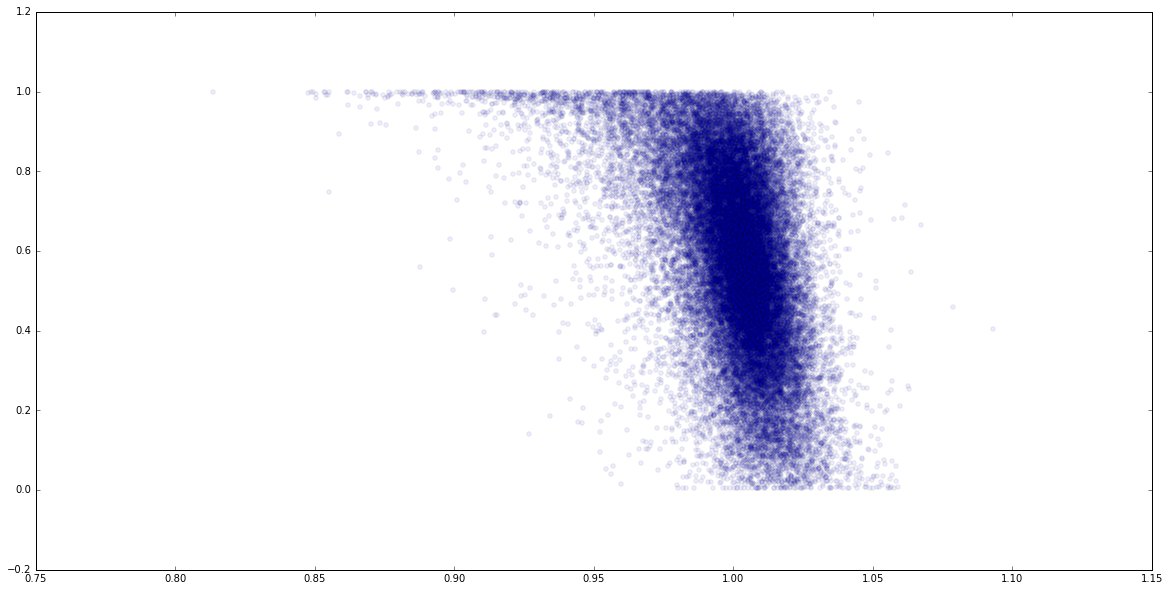

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df.ranks,df.outcomes,alpha=.07);

In [31]:
X,y = df['ranks'].values,df.outcomes

In [32]:
X = sm.add_constant(X)

In [33]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               outcomes   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                 1.115e+04
Date:                Wed, 31 Aug 2016   Prob (F-statistic):               0.00
Time:                        11:27:43   Log-Likelihood:                 6429.3
No. Observations:               38282   AIC:                        -1.285e+04
Df Residuals:                   38280   BIC:                        -1.284e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.5076      0.056    116.018      0.0

In [144]:
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(X[:,None])

In [134]:
cross_val_score(ols,X,y,cv=10).mean()

0.24188285592488201

In [135]:
X.shape

(13645, 3)

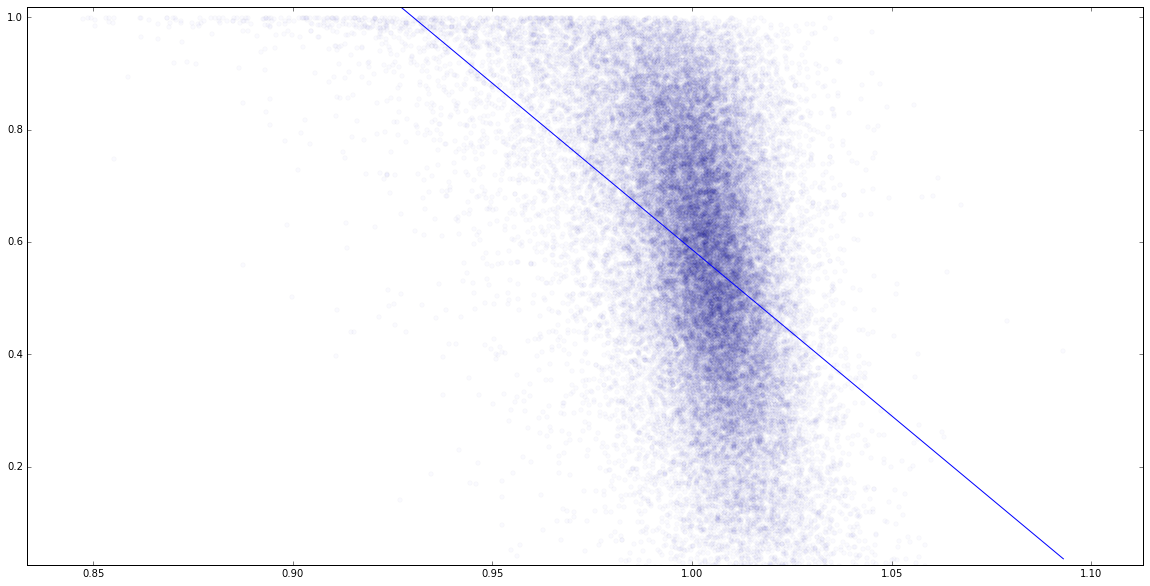

In [34]:
ratings,outcomes = np.array(df.ranks),np.array(df.outcomes)
ols.fit(ratings[:,None],outcomes)
# iso.fit(ratings,outcomes)
predictions_o = ols.predict(np.sort(ratings)[:,None])
# predictions_i = iso.predict(np.sort(ratings))
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(ratings,outcomes,alpha=.02)
plt.plot(np.sort(ratings),predictions_o)
# plt.plot(np.sort(ratings),predictions_i)
plt.xlim(df.ranks.min()+.02,df.ranks.max()+.02);
plt.ylim(df.outcomes.min()+.02,df.outcomes.max()+.02);

In [50]:
print n_round_groups
print S.shape[0]**2

7
1768900


In [51]:
print len(S.nonzero()[1])/float(S.shape[0]**2)

0.15487704223


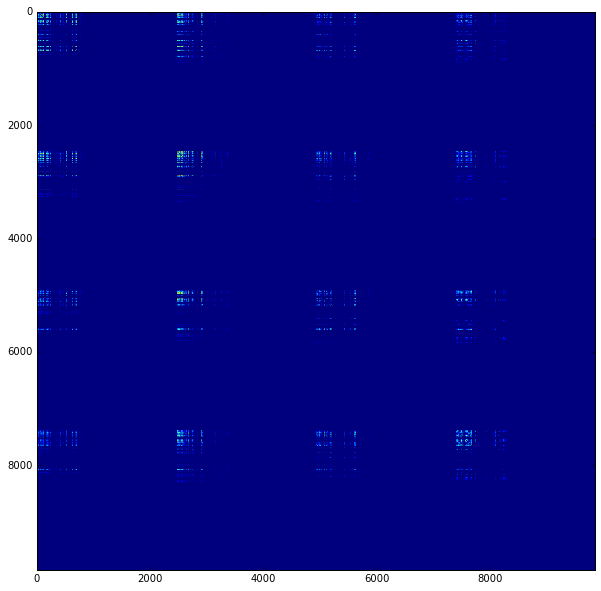

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A[10*n_players:14*n_players,10*n_players:14*n_players].toarray());

In [19]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [18]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[90]}).sort_values('rank',ascending=False).dropna()

,player_ind,player_name,rank
1823,1823,"Jeong, Jin",1.044972
118,118,"Kuboya, Kenichi",1.040941
531,531,"Garrido, Ignacio",1.039769
1837,1837,"Hamilton, Alex",1.037443
337,337,"Westwood, Lee",1.036883
1749,1749,"Presnell, Alistair",1.036119
1795,1795,"Langley, Scott",1.035048
174,174,"Stricker, Steve",1.034086
562,562,"Dredge, Bradley",1.032628
1000,1000,"Gallacher, Stephen",1.031832


In [20]:
names_to_ind = {inds_to_name[key]:key for key in inds_to_name}

In [59]:
inds_to_plot = [names_to_ind['Woods, Tiger'],names_to_ind['Spieth, Jordan']]

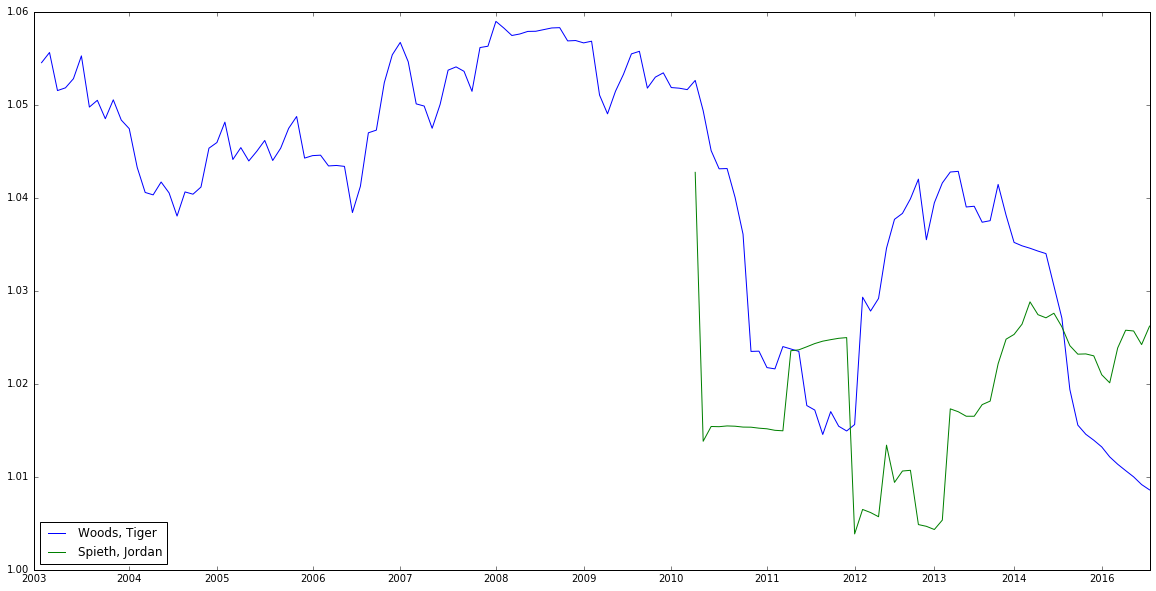

In [60]:
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    plt.plot([ranks[i][j] for i in range(len(ranks))],label = inds_to_name[j]);
plt.legend(loc=3);
plt.xticks([i[1] for i in year_inds], [i[0] for i in year_inds]);

In [42]:
year_inds = [max([map(int,[i.split(',')[0] for i in j])]) for j in tournament_groups]

In [43]:
from collections import Counter
year_inds = [Counter(i) for i in year_inds]

In [45]:
year_inds = [sorted(i,key=year_inds[u].get,reverse=True)[0] for u,i in enumerate(year_inds)]

In [51]:
year_inds = np.array(year_inds)
year_inds = [(year,np.argwhere(year_inds==year).min()) for year in range(2003,2015)+range(2016,2017)]

In [52]:
year_inds

[(2003, 0),
 (2004, 12),
 (2005, 23),
 (2006, 35),
 (2007, 46),
 (2008, 58),
 (2009, 69),
 (2010, 80),
 (2011, 92),
 (2012, 103),
 (2013, 113),
 (2014, 123),
 (2016, 134)]